In [5]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, AdaptiveFCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

In [6]:
class KdV(Problem):
    @staticmethod
    def init_params(c=1,a=1):
        
        static_params = {
            'dims': (2,2),
            'c': c,
            'a': a,
        }
        return static_params, {}
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(1,)),
            (0,(1,1,1,)),
        )

        return [
            [x_batch_phys, required_ujs_phys],
        ]

    @staticmethod
    def loss_fn(all_params, constraints):
        x_batch, u, ut, ux, uxxx = constraints[0]
        phys = jnp.mean((-ut - uxxx + 6*u*ux)**2)
        return phys

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):        
        c, a = all_params['static']['problem']['c'], all_params['static']['problem']['a']
        t, x = x_batch[:, 0:1], x_batch[:, 1:2]
        shifted_x = x-c*t-a
        sech_arg = 0.5 * jnp.sqrt(c) * shifted_x
        phi = 0.5 * c * (1/jnp.cosh(sech_arg))**2
        return phi

In [7]:
n1, n2 = 20, 6
subdomain_xs = [np.linspace(0., 1.5, n2),np.linspace(-5., 5., n1)]
subdomain_ws = get_subdomain_ws(subdomain_xs, 2.7)

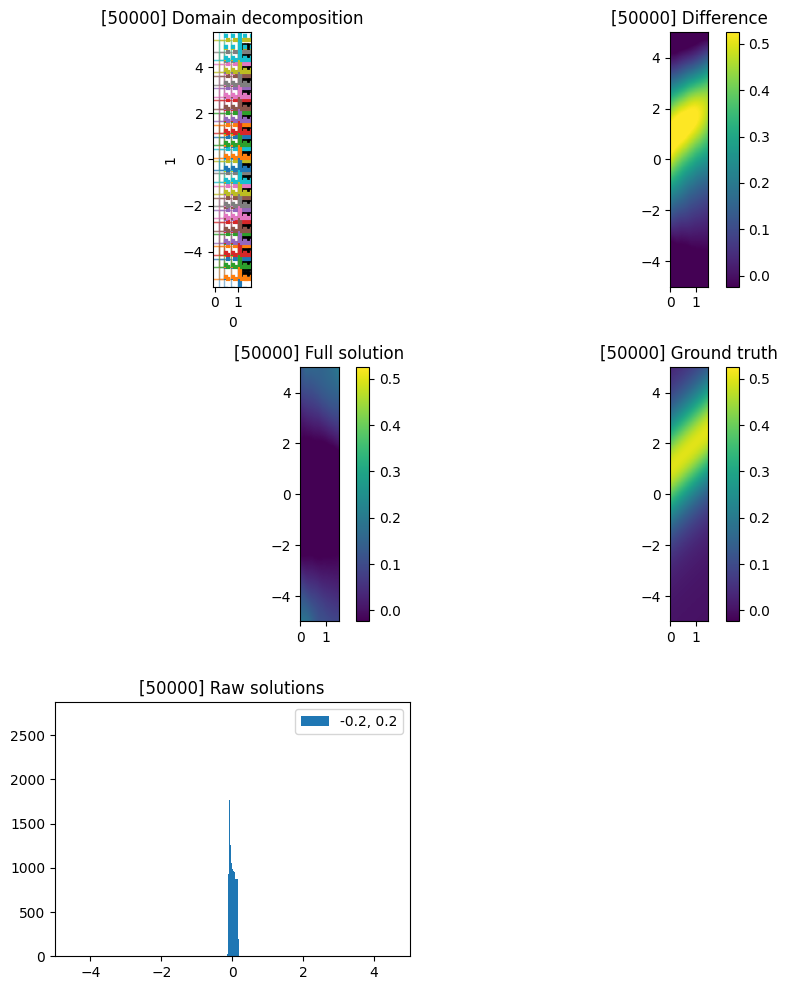

[INFO] 2024-05-03 15:13:04 - [i: 50000/50000] Training complete


In [8]:
c = Constants(
    run = "TEST_KDV",
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0., -5.]),
        xmax=np.array([1.5, 5.]),
    ),
    problem=KdV,
    problem_init_kwargs=dict(c=1, a=1),
    decomposition = RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs = subdomain_xs,
        subdomain_ws = subdomain_ws,
        unnorm=(0., 1.),
    ),
    network=FCN,
    network_init_kwargs=dict(
        layer_sizes = [2,16,1],
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=1,
    ),
    ns = ((60,200),),
    n_test = (60,200),
    n_steps = 50000,
    optimiser_kwargs=dict(learning_rate=1e-3),
    show_figures=True,
    clear_output=True);

run = FBPINNTrainer(c)
all_params = run.train()

In [9]:
class Laplace2D_quadratic(Problem):

    @staticmethod
    def init_params(sd=0.2):
        static_params = {
            "dims":(1,2),
            "sd":sd,
            }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        tanh, sd = jnp.tanh, all_params["static"]["problem"]["sd"]
        x, y = x_batch[:,0:1], x_batch[:,1:2]
        u = tanh((x-0)/sd)*tanh((1-x)/sd)*tanh((y-0)/sd)*tanh((1-y)/sd)*u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        x_batch,uxx,uyy = constraints[0]
        x, y = x_batch[:,0:1], x_batch[:,1:2]
        f = 32*(x*(1-x)+y*(1-y))
        phys = f + uxx + uyy
        return jnp.mean(phys**2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        x, y = x_batch[:,0:1], x_batch[:,1:2]
        u = 16*(x*(1-x)*y*(1-y))
        return u

In [17]:
def generate_constraints(overlap, arch, sub: tuple, name):
    c_lap = Constants(
    run = name,
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0., 0.]),
        xmax=np.array([1, 1.]),
    ),
    problem=Laplace2D_quadratic,
    problem_init_kwargs=dict(sd=0.2),
    decomposition = RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs = [np.linspace(0., 1., sub[0]),np.linspace(0., 1., sub[1])],
        subdomain_ws = get_subdomain_ws([np.linspace(0., 1., sub[0]),np.linspace(0., 1., sub[1])], overlap),
        unnorm=(0., 1.),
    ),
    network=FCN,
    network_init_kwargs=dict(
        layer_sizes = arch,
    ),
    ns = ((80,80),),
    n_test = (200,200),
    n_steps = 50000,
    optimiser_kwargs=dict(learning_rate=1e-3),
    show_figures=True,
    clear_output=True)
    return c

#run_lap = FBPINNTrainer(c_lap)
#all_params = run_lap.train()

In [18]:
overlaps = [1.1, 1.5, 1.9, 2.3, 2.7]
archs = [
    [2, 4, 1],
    [2, 8, 1],
    [2, 16, 1],
    [2, 32, 1],
    [2, 64, 1]
]
archs_2layers = [
    [2, 4, 4, 1],
    [2, 8, 8, 1],
    [2, 16, 16, 1],
]
subdomains = [(5,5), (10,10), (20,20), (40,40)]

In [ ]:
for sub in subdomains:
    run = FBPINNTrainer(generate_constraints(1.1, [2,16,1], sub, None))
    all_params = run.train()

[INFO] 2024-05-03 16:20:32 - <fbpinns.constants.Constants object at 0x7b5205fe67b0>
run: TEST_KDV
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([ 0., -5.]), 'xmax': array([1.5, 5. ])}
problem: <class '__main__.KdV'>
problem_init_kwargs: {'c': 1, 'a': 1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0. , 0.3, 0.6, 0.9, 1.2, 1.5]), array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ])], 'subdomain_ws': [array([0.81, 0.81, 0.81, 0.81, 0.81, 0.81]), array([1.42105263, 1.42105263, 1.42105263, 1.42105263, 1.42105263,
       1.42105263, 1.42105263, 1.42105263, 1.42105263, 1.42105263,
       1.42105263, 1.42105263, 1.42105263, 1.42105263, 1.